# Notebook to plan out the form of the optimal estimator

In [4]:
import numpy as np
import sys
sys.path.append('..')
import skewer_computations as skc
import os
import matplotlib.pyplot as plt
# from fake_spectra import spectra as spec
import time
%load_ext autoreload
%autoreload 2

# Goal: estimate deviations from a fiducial Px spectrum

$$P_\times(z,\Delta \theta,k_\parallel) =  P_\times^{\rm
   fid}(z,\Delta \theta,k_\parallel) + \sum_\alpha ~ \Theta_\alpha(\Delta \theta) 
    ~ w^\times_\alpha(z, k_\parallel) ~ p^\times_\alpha ~ $$
    
$    w^\times_\alpha(z, k_\parallel)$ is an interpolation kernel, $ \Theta_\alpha(\Delta \theta) $ is top hat filter in transverse.  $p_\alpha = P^\times(k_\alpha) − P^\times_\mathrm{fid}(k_\alpha)$ are the cross-spectrum parameters we want to measure, i.e., the deviations from the fiducial power spectrum.

### Load the data.
We're working in pixel space

In [5]:
# set sim_name
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
# set snapnum
snap_num = 6
# set phase
phase = "sim_plus"
# set axis number
axis = 2

In [6]:
# get the measurements for this set
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
Px_info = np.load(meas_path+"snap_{:d}/Px_skewers_{:.2f}_{:.2f}_allax_allphase.npz".format(snap_num,0.05,0.13))
Px_meas_0 = Px_info['Px']
L= Px_info['L']
Np = int(Px_info['Np'])
spacing = L/Np
kpar_meas = np.fft.rfftfreq(Np, spacing)*2*np.pi # frequency in Mpc^-1

In [7]:
# load the skewers as npz file
delta_ks = np.load(meas_path+"snap_{:d}/delta_k/skewers_6_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))

In [8]:
delta_flux_k = delta_ks['delta_flux_k'] # these are already normalized
kpar = delta_ks['kpar']
L = delta_ks['L_Mpc']
pix_spacing = delta_ks['los_spacing_Mpc']

In [9]:
Nk = delta_flux_k.shape[1]
nskew = delta_flux_k.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])
subsel=True
nsub=100
if subsel:
    randoms = np.random.choice(len(positions), size=nsub)
    sel = np.zeros(len(positions), dtype=bool)
    sel[randoms] = True
else:
    sel = np.ones(len(positions), dtype=bool)
positions_sel = np.copy(positions)
positions_sel[~sel] = np.nan
delta_flux_k[~sel] = np.nan
# reshape into a grid
delta_flux_k = np.reshape(delta_flux_k, (int(nside), int(nside), Nk))
position_grid = np.reshape(positions_sel, (int(nside), int(nside), 2))

Box is 67.5 Mpc per side with 768 skewers per side
spacing between neighboring skewers is 0.09 Mpc


/Users/mlokken/anaconda3/envs/pcross/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/mlokken/anaconda3/envs/pcross/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


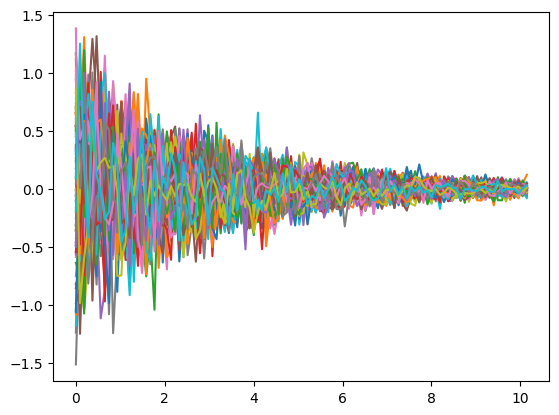

plotted 100 spectra


In [10]:
# plot the spectra that are not nan
counter = 0
for i in range(nside):
    for j in range(nside):
        if np.isnan(delta_flux_k[i,j]).any():
            continue
        plt.plot(kpar, delta_flux_k[i,j])
        counter += 1
plt.show()
print(f"plotted {counter} spectra")

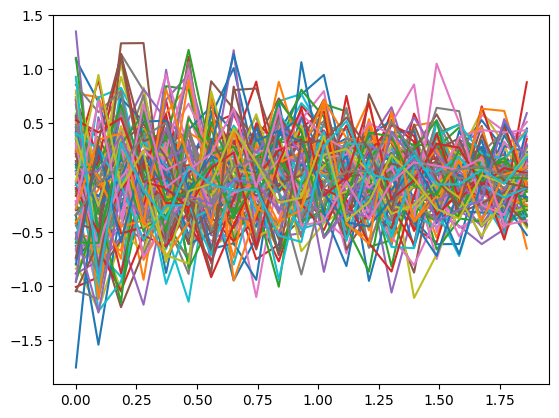

plotted 100 spectra


In [13]:
# cut off the delta_ks at 20
kpar_cut = 2
kpar_cut_ind = np.where(kpar < kpar_cut)[0][-1]
delta_flux_k = delta_flux_k[:,:,:kpar_cut_ind]
kpar = kpar[:kpar_cut_ind]
# plot the spectra that are not nan
counter = 0
for i in range(nside):
    for j in range(nside):
        if np.isnan(delta_flux_k[i,j]).any():
            continue
        plt.plot(kpar, delta_flux_k[i,j])
        counter += 1
plt.show()
print(f"plotted {counter} spectra")

In [11]:
# close the file
delta_ks.close()

In [12]:
# # specify path to test simulations
# data_path = "/data/desi/common/HydroData/Emulator/post_768/Australia20" # in PIC
# # specify simulation in suite
# sk_fname="skewers_{}_Ns768_wM0.05_sT1.0_sg1.0.hdf5".format(snap_num)
# subsel = True
# if not os.path.exists("/data/desi/scratch/mlokken/Px_skewers/{}/snap_{}/skewers_{}_Ns768_wM0.05_sT1.0_sg1.0_{}_p{}_skew{}.npy".format(sim_dir, snap_num, snap_num,sim_name, phase, axis)):
#     print("Collecting spectra for phase {}, skewer {}".format(phase, axis))
#     sk_dir="{}/{}/{}/skewers_{}".format(data_path,sim_name, phase, axis)
#     # reconstruct filename with skewers
#     print("will load skewers from file {} in directory {}".format(sk_fname,sk_dir))
#     # create Spectra object from fake_spectra repo
#     spectra = spec.Spectra(num=snap_num,base="NA",cofm=None,axis=None,savedir=sk_dir,savefile=sk_fname,
#                      res=None,reload_file=False,load_snapshot=False,quiet=False)
#     Lh = spectra.box/1000
#     L = Lh/spectra.hubble
#     print(f"Box is {L} Mpc per side")
#     z = spectra.red
#     if axis==1:
#         axes = [1,2] # yz plane
#     elif axis==2:
#         axes = [0,2] # xz plane
#     elif axis==3:
#         axes = [0,1]
#     pos1 = spectra.cofm[:,axes[0]]/1000/spectra.hubble
#     pos2 = spectra.cofm[:,axes[1]]/1000/spectra.hubble
#     positions = np.column_stack([pos1,pos2])

#     if subsel:
#         randoms = np.random.choice(len(positions), size=100)
#         sel = np.zeros(len(positions), dtype=bool)
#         sel[randoms] = True
#     else:
#         sel = np.ones(len(pos1), dtype=bool)
#     positions_sel = np.copy(positions)
#     positions_sel[~sel] = np.nan
#     nside = int(np.sqrt(len(pos1)))
#     position_grid       = positions.reshape((nside,nside,2))
#     position_grid_sel   = positions_sel.reshape((nside,nside,2))
#     delta_flux=skc.delta(spectra.get_tau('H',1,1215))
#     delta_flux[~sel] = np.nan
#     Ns,Np=delta_flux.shape
#     pix_spacing = L/Np
#     print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")
#     # bin delta_flux along line-of-sight
#     delta_flux_binned = bin_spectra(delta_flux, 20)

#     Ns_b,Np_b=delta_flux_binned.shape
#     pix_spacing = L/Np_b
#     print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing} Mpc")
#     delta_flux_grid = delta_flux_binned.reshape((nside,nside,Np_b))

Our sub-selected spectra are distributed randomly across the plane:

Text(0, 0.5, 'y [Mpc]')

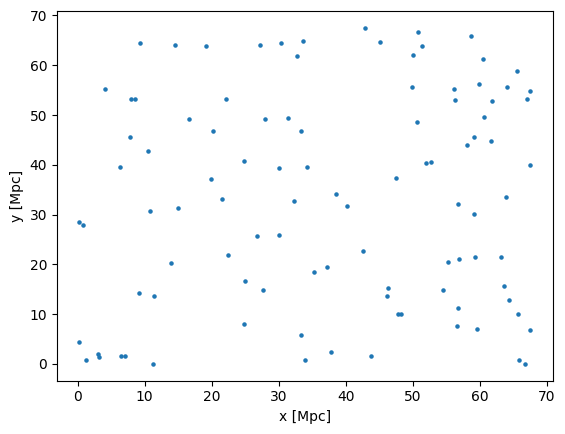

In [13]:
plt.scatter(positions_sel[:,0], positions_sel[:,1], s=5)
plt.xlabel("x [Mpc]")
plt.ylabel("y [Mpc]")

Define the bin we are going to measure.

Plotting separations for bin [2, 2.5].
236


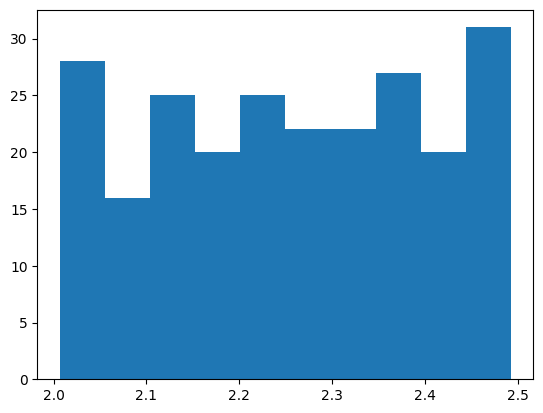

In [14]:
separation_bins = [2, 2.5, 3]

distances = np.linalg.norm(positions-[0,0], axis=1)
dgrid = distances.reshape(position_grid.shape[0:2])

s=0
sbin = [separation_bins[0],separation_bins[1]]
m_offsets, n_offsets = skc.offsets_inbin(positions, position_grid.shape[0:2],sbin)

print(f"Plotting separations for bin {sbin}.")


dists_remain = []
for i in range(len(m_offsets)):
    dists_remain.append(dgrid[m_offsets[i], n_offsets[i]])
plt.hist(dists_remain)
print(len(dists_remain))

# Define the first global weighting matrix by setting the fiducial Px for this separation.
However, if following F-R+18, the weighting matrix will be P1D at Delta-theta = 0 and 0 everywhere else.
So, we don't actually need to make the Px predictions. The following few boxes will be hidden.

In [15]:
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
path_program = "/Users/mlokken/research/lyman_alpha/software/ForestFlow/"

folder_lya_data = path_program + "data/best_arinyo/"

Archive3D = GadgetArchive3D(
    base_folder=path_program[:-1],
    folder_data=folder_lya_data,
    force_recompute_plin=False,
    average="both",
)

In [16]:
central = Archive3D.get_testing_data("mpg_central")
zs = np.array([central[snap_num]['z']]) 

k3d_Mpc = central[snap_num]['k3d_Mpc']
mu3d = central[snap_num]['mu3d']
p3d_Mpc = central[snap_num]['p3d_Mpc']
Plin = central[snap_num]['Plin']

k1d_Mpc = central[snap_num]['k_Mpc']
p1d_Mpc = central[snap_num]['p1d_Mpc']

arinyo_params = central[snap_num]['Arinyo'] # best-fitting Arinyo params
cosmo_params  = central[snap_num]['cosmo_params']

print(zs)
arinyo_params

[3.]


{'bias': -0.2265946739714242,
 'beta': 1.2248241556400337,
 'q1': 0.5508070368332233,
 'kvav': 0.7735041489709146,
 'av': 0.5316646888234277,
 'bv': 1.841648720663841,
 'kp': 13.45975658765607,
 'q2': 0.1882466279205535}

In [17]:
cosmo = camb_cosmo.get_cosmology_from_dictionary(cosmo_params)
camb_results = camb_cosmo.get_camb_results(cosmo, zs=zs, camb_kmax_Mpc=1000)
arinyo = ArinyoModel(cosmo=cosmo, camb_results=camb_results, zs=zs, camb_kmax_Mpc=1000)
p1d = arinyo.P1D_Mpc(zs[0], kpar, parameters=arinyo_params) # get P1D at target z

# R2 = separation_bins[1]
# R1 = separation_bins[0]
# rperp_choice = 2/3. * (R2**3-R1**3)/(R2**2-R1**2)
# print(rperp_choice)
# rperp_pred,Px_per_kpar_pred = pcross.Px_Mpc_detailed(kpar[1:66],
# arinyo.P3D_Mpc,
# zs[0],
# rperp_choice=[rperp_choice],
# P3D_mode='pol',
# min_kperp=10**-3,
# nkperp=2**12,
# **{'pp':arinyo_params})

# Run the algorithm

Loop through all skewer pairs within this bin

In [18]:
# def W_k(k,pix_width):
    # define the window function
    # W_k is just a delta function because 
# def Cij_alpha(spec1, spec2, kpar, n, pix_width):
#     # Naim's Eq 14 with an exponential factor
#     # kpar is the array of kpar
#     # n is the kpar where the integral will begin
    
    
#     # define the window function
#     # R = 71600
#     # delta_lambda = c/R # in velocity units
#     # W_k = np.exp(-kpar**2*delta_lambda**2/2)*np.sinc(kpar*pix_width/2)

#     # for now, just nix the resolution part
#     # both spectra have the pixel width so we can just define this once

#     # define the interpolation kernel
#     # not going to bother with this, do this at one redshift only for now
    
#     # define the matrix
#     Cij_alpha = np.zeros((len(spec1),len(spec2)))
#     for i in range(len(spec1)):
#         for j in range(len(spec2)):
#             delx_ij = np.abs(xpar[j]-xpar[i])
#             # if j==0:
#             #     linestyle='dashed'
#             # else:
#             #     linestyle='solid'
#             kpar_range = np.logspace(np.log10(kpar[n]), np.log10(kpar[n+1]),10)
#             W_kpar     = W_k(kpar_range, pix_width)
#             y = 1. / (np.pi) * np.cos(kpar_range*delx_ij) * W_kpar**2 #taking away the factor of 2 in denom, since we're representing with cos
#             # plt.plot(kpar_range, y, linestyle=linestyle)
#             Q_ij = np.trapz(y, kpar_range)
#             Cij_alpha[i,j]=Q_ij
#     return Cij_alpha
def Cij_alpha_approx(spec1, kbin_est_alpha, k_input):
    # zeros matrix
    Cij_alpha = np.zeros((len(spec1),len(spec1)))
    # for every k_input within the bin kbin_est_alpha, set the diagonal to 1
    k_input_n = np.where((k_input > kbin_est_alpha[0]) & (k_input < kbin_est_alpha[1]))[0]
    Cij_alpha[k_input_n, k_input_n] = 1
    return Cij_alpha



def C_0(arinyo, z, arinyo_params, kpar):
    # xi_fid should be a function
    C_0 = np.zeros((len(kpar),len(kpar)))
    np.fill_diagonal(C_0, arinyo.P1D_Mpc(z, kpar, parameters=arinyo_params))
    return C_0

In [19]:
C_0_mat = C_0(arinyo, zs[0], arinyo_params, kpar)

In [20]:
arinyo.P1D_Mpc(zs[0], np.array([1]), parameters=arinyo_params)

array([0.24576382])

([<matplotlib.axis.YTick at 0x314751910>,
 [Text(0, 0, '0.0'),
  Text(0, 10, '0.930842267730309'),
  Text(0, 20, '1.861684535460618'),
  Text(0, 30, '2.7925268031909276'),
  Text(0, 40, '3.723369070921236'),
  Text(0, 50, '4.654211338651546'),
  Text(0, 60, '5.585053606381855'),
  Text(0, 70, '6.5158958741121635'),
  Text(0, 80, '7.446738141842472'),
  Text(0, 90, '8.377580409572783'),
  Text(0, 100, '9.308422677303092')])

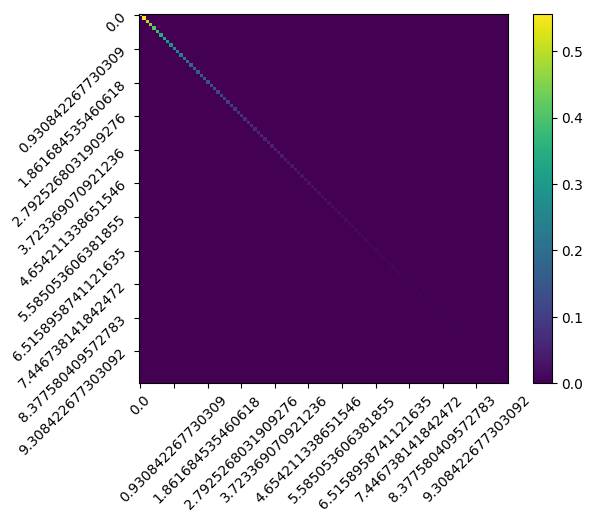

In [21]:
from matplotlib.ticker import FormatStrFormatter
plt.imshow(C_0_mat)
plt.colorbar()
plt.xticks(np.arange(len(kpar))[::10], kpar[::10], rotation=45)
plt.yticks(np.arange(len(kpar))[::10], kpar[::10], rotation=45)

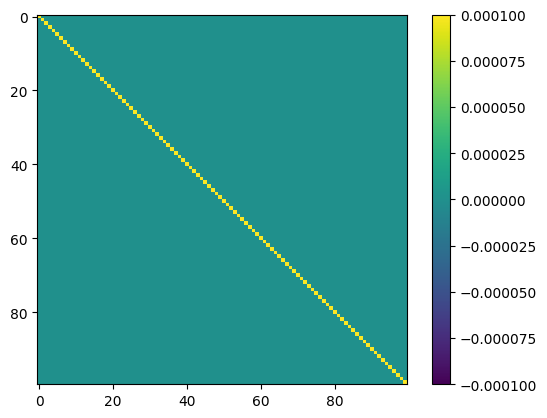

In [22]:
plt.imshow(C_0_mat[0:100,0:100], vmin=-1e-4, vmax=1e-4)
plt.colorbar()

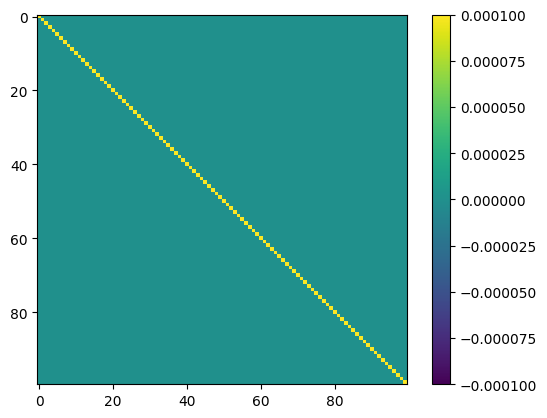

In [23]:
C_0_invmat = np.linalg.inv(C_0_mat)
plt.imshow(C_0_invmat[0:100,0:100], vmin=-1e-4, vmax=1e-4)
plt.colorbar()

In [24]:
# Lalpha_term1 = np.zeros(len(kpar))
# Lalpha_term2 = np.zeros(len(kpar))

# Lalpha_beta  = np.zeros((len(kpar),len(kpar)))
# # each k mode, given separation bin s, is a parameter alpha
# # for simplification let us do only P1D and one non-zero separation bin
# # here is the case for the non-zero separation bin defined earlier
# # for k in range(1,len(kpar)):
# for k in range(1,5): # our alpha
#     start = time.time()
#     print(f"Running (alpha)=k={kpar[k]}")
#     for m in range(nside):
#         for n in range(nside):
#             # for this I=[m,n] skewer, get 1 and 2 data vectors for all pairs within separation bin
#             # I = [m,n]
#             delta_I = delta_flux_grid[m,n][:, np.newaxis]
#             # print(f"Skewer I is at [{m,n}] and value {delta_I}")
#             if not np.isnan(delta_I).any():
#                 # make m and n arrays of the same length as the offsets
#                 mvec = np.full(len(m_offsets), m)
#                 nvec = np.full(len(n_offsets), n)
#                 m2lr = (mvec+m_offsets)%nside # first quadrant, periodic boundary conditions
#                 n2lr = (nvec+n_offsets)%nside
#                 m2ul = (mvec-m_offsets)%nside # second quadrant
#                 n2ul = (nvec-n_offsets)%nside
#                 # reduce all to those which are within the full grid
#                 quad1include = (m2lr<nside) & (n2lr<nside)
#                 m2lr = (m2lr[quad1include]).astype(int)
#                 n2lr = (n2lr[quad1include]).astype(int)
#                 quad2include = (m2ul<nside) & (n2ul<nside)
#                 m2ul = (m2ul[quad2include]).astype(int)
#                 n2ul = (n2ul[quad2include]).astype(int)
#                 # Check that you have pairs.
#                 quad1len = len(m2lr)
#                 quad2len = len(m2ul)
#                 tot_in_bin = quad1len+quad2len
#                 if tot_in_bin==0:
#                     sys.exit(f"Not finding any pairs for grid point {m}, {n}")
                
#                 # now loop through all the pairs J for this I skewer
#                 for c in range(len(m2lr)):
#                     delta_J = delta_flux_grid[m2lr[c],n2lr[c]] # this is quasar J at [m2lr[c],n2lr[c]] which is sep away from quasar I at [m,n]
#                     if not np.isnan(delta_J).any():
#                         delta_J = delta_J[:, np.newaxis]
#                         # get the exact separation
#                         delta_theta = np.linalg.norm(position_grid[m2lr[c],n2lr[c]]-position_grid[m,n])
#                         # get the derivative matrix from function Cij_alpha
#                         Cij_alpha_IJ = Cij_alpha(delta_I, delta_J, delta_theta, kpar, k, pix_spacing)
#                         y_I = np.matmul(C_0_invmat,delta_I)
#                         y_J = np.matmul(C_0_invmat,delta_J)
#                         Lalpha_term1[k] += np.matmul(np.matmul(y_I.T, Cij_alpha_IJ), y_J)[0][0]
#                         for kprime in range(1,5): # our beta
#                             # compute the second derivative
#                             Cij_beta_JI = Cij_alpha(delta_J, delta_I, kpar, kprime, pix_spacing)
#                             # C0_invmat is the same for I and J, since no noise in sim
#                             Lalpha_beta[k, kprime] += np.trace(np.matmul(np.matmul(np.matmul(C_0_invmat, Cij_alpha_IJ), C_0_invmat), Cij_beta_JI))
#         print(f"m={m}.")
#             # do not need to get term 2 as the second term is zero for derivatives w.r.t. non-P1D
    
#     end = time.time()
#     print(f"This k took {start-end} seconds")
# Lalpha_term1*=0.5
# # Lalpha_term2*=0.5
# Lalpha_beta*=-0.5
# L_alpha = Lalpha_term1-Lalpha_term2



print("Starting P1D")

# here is the case for P1D, zero separation
# Choose our desired binning for the k modes
kbin_est = np.linspace(0, kpar[-1], 5)
kbin_est_centers = (kbin_est[1:]+kbin_est[:-1])/2
print(kbin_est_centers)
# set up the first derivative matrix
Lalpha_term1 = np.zeros(len(kbin_est_centers))
# Lalpha_term2 = np.zeros(len(kpar))

F_alpha_beta  = np.zeros((len(kbin_est_centers),len(kbin_est_centers)))

for k in range(len(kbin_est)-1):
    # this loop we will find the P1D for k within [kbin_est[k], kbin_est[k+1]]
    start = time.time()
    print(f"Running (alpha)=k={kpar[k]}")
    counter = 0
    for m in range(nside):
        # if m%50==0:
        #     print(f"m={m}")
        for n in range(nside):
            # for this I=[m,n] skewer, get 1 and 2 data vectors for all pairs within separation bin
            delta_I = delta_J = delta_flux_k[m,n][:, np.newaxis]
            if not np.isnan(delta_I).any():
                print(f"m={m}, n={n}")
                counter+=1
                if counter==10:
                    break
                if counter%10==0:
                    print(f"percent done: {counter/nsub*100}")
                # print(f"Skewer I is at [{m,n}]") # and value {delta_I}
                
                # get the derivative matrix from function Cij_alpha
                Q_alpha = Cij_alpha_approx(delta_I, [kbin_est[k], kbin_est[k+1]], kpar)
                y_I = y_J = np.matmul(C_0_invmat,delta_I)
                d_alpha = np.matmul(np.matmul(y_I.T, Q_alpha), np.conjugate(y_J))
                t_alpha = np.trace(np.matmul(np.matmul(np.matmul(C_0_invmat, Q_alpha), C_0_invmat), C_0_mat))
                # for kprime in range(1,5): # our beta
                for kprime in range(len(kbin_est)-1):
                    # compute the second derivative
                    Q_beta = Cij_alpha_approx(delta_I, [kbin_est[kprime], kbin_est[kprime+1]], kpar)
                    F_alpha_beta[k,kprime] += 0.5*np.trace(np.matmul(np.matmul(np.matmul(C_0_invmat, Q_alpha), C_0_invmat), Q_beta))
                # for this k, add the terms from this (m,n) skewer to the total derivative
                Lalpha_term1[k] += np.real(d_alpha - t_alpha)
                # print("Computing derivative.")
                # timeder = time.time()
                ## the derivative computation is the slow part.
                
                # compute the second derivative
                # print("Computing derivative.")
                # C0_invmat is the same for I and J, since no noise in sim
                
    end = time.time()
    print(f"This k took {end-start} seconds")


# print("Now starting Px")

# # Choose our desired binning for the k modes
# kbin_est = np.linspace(0, kpar[-1], 1)
# kbin_est_centers = (kbin_est[1:]+kbin_est[:-1])/2

# # set up the first derivative matrix
# N_params = len(kbin_est_centers)*len(separation_bins)
# Lalpha_term1 = np.zeros(N_params)

# F_alpha_beta  = np.zeros((N_params,N_params))

# for s in range(len(separation_bins)):
#     # this loop we will find the Px for separation bin [separation_bins[s], separation_bins[s+1]]
#     for k in range(len(kbin_est)-1):
#         # this loop we will find the Px for k within [kbin_est[k], kbin_est[k+1]]
#         start = time.time()
#         print(f"Finding Px_alpha such that k={kpar[k]} and s={separation_bins[s]}")
#         counter = 0
#         for m in range(nside):
#             # if m%50==0:
#             #     print(f"m={m}")
#             for n in range(nside):
#                 # for this I=[m,n] skewer, get 1 and 2 data vectors for all pairs within separation bin
#                 delta_I = delta_flux_k[m,n][:, np.newaxis]
#                 if not np.isnan(delta_I).any():
#                     print(f"m={m}, n={n}")
#                     counter+=1
#                     if counter==10:
#                         break
#                     if counter%10==0:
#                         print(f"percent done: {counter/nsub*100}")
#                     # print(f"Skewer I is at [{m,n}]") # and value {delta_I}
                    
#                     # get the derivative matrix from function Cij_alpha
#                     Q_alpha = Cij_alpha_approx(delta_I, [kbin_est[k], kbin_est[k+1]], kpar)
#                     y_I = y_J = np.matmul(C_0_invmat,delta_I)
#                     d_alpha = np.matmul(np.matmul(y_I.T, Q_alpha), np.conjugate(y_J))
#                     t_alpha = np.trace(np.matmul(np.matmul(np.matmul(C_0_invmat, Q_alpha), C_0_invmat), C_0_mat))
#                     # for kprime in range(1,5): # our beta
#                     for kprime in range(len(kbin_est)-1):
#                         # compute the second derivative
#                         Q_beta = Cij_alpha_approx(delta_I, [kbin_est[kprime], kbin_est[kprime+1]], kpar)
#                         F_alpha_beta[k,kprime] += 0.5*np.trace(np.matmul(np.matmul(np.matmul(C_0_invmat, Q_alpha), C_0_invmat), Q_beta))
#                     # for this k, add the terms from this (m,n) skewer to the total derivative
#                     Lalpha_term1[k] += np.real(d_alpha - t_alpha)
#                     # print("Computing derivative.")
#                     # timeder = time.time()
#                     ## the derivative computation is the slow part.
                    
#                     # compute the second derivative
#                     # print("Computing derivative.")
#                     # C0_invmat is the same for I and J, since no noise in sim
                    
#         end = time.time()
#         print(f"This k took {end-start} seconds")



Starting P1D
[1.26827259 3.80481777 6.34136295 8.87790813]
Running (alpha)=k=0.0
m=3, n=51
m=3, n=323
m=9, n=316
m=14, n=8
m=34, n=23
m=36, n=16
m=47, n=628
m=72, n=449
m=73, n=17
m=80, n=18
m=89, n=519
m=91, n=604
m=97, n=605
m=104, n=163
m=105, n=733
m=119, n=487
m=123, n=348
m=128, n=0
m=130, n=155
m=158, n=231
percent done: 20.0
m=165, n=729
m=170, n=357
m=189, n=559
m=218, n=725
m=226, n=422
m=230, n=531
m=245, n=377
m=252, n=605
m=255, n=248
m=281, n=91
percent done: 30.0
m=282, n=464
m=283, n=190
m=303, n=291
m=309, n=728
m=314, n=168
m=317, n=558
m=341, n=294
m=341, n=448
m=345, n=733
m=356, n=562
percent done: 40.0
m=367, n=371
m=371, n=702
m=378, n=65
m=378, n=532
m=382, n=738
m=386, n=10
m=388, n=449
m=400, n=209
m=422, n=221
m=429, n=27
percent done: 50.0
m=437, n=389
m=456, n=360
m=484, n=258
m=487, n=767
m=497, n=18
m=512, n=736
m=524, n=156
m=525, n=174
m=540, n=424
m=543, n=115
percent done: 60.0
m=548, n=113
m=566, n=633
m=568, n=705
m=575, n=553
m=576, n=758
m=584, n=

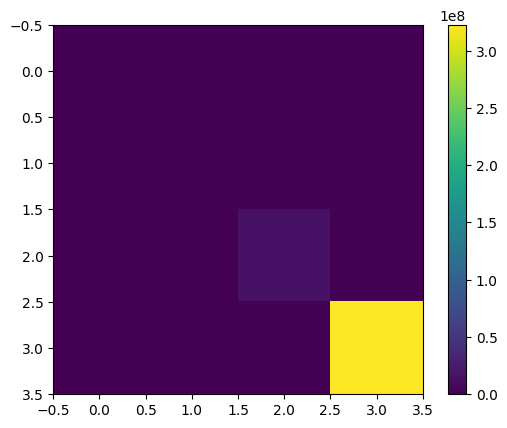

In [25]:
plt.imshow(F_alpha_beta)
plt.colorbar()

In [26]:
theta_est = 1/2*np.matmul(np.linalg.inv(F_alpha_beta), Lalpha_term1)

# Compute the $p_\alpha$ estimates

In [27]:
# reshape delta_flux_k to be Ns x Np again
delta_flux_k_flat = np.ma.masked_array(np.reshape(delta_flux_k, (nskew, len(kpar))))
pk_all=abs(delta_flux_k_flat)**2
pk_avg = np.average(pk_all, axis=0) # average over all skewers in this axis


In [28]:
# bin p1d to match kbin_est binning
p1d_fid_binned = np.zeros(len(kbin_est_centers))
for i in range(len(kbin_est)-1):
    kbin = np.where((kpar > kbin_est[i]) & (kpar < kbin_est[i+1]))[0]
    p1d_fid_binned[i] = np.average(p1d_Mpc[kbin])

Text(0.5, 0, '$k_\\parallel$')

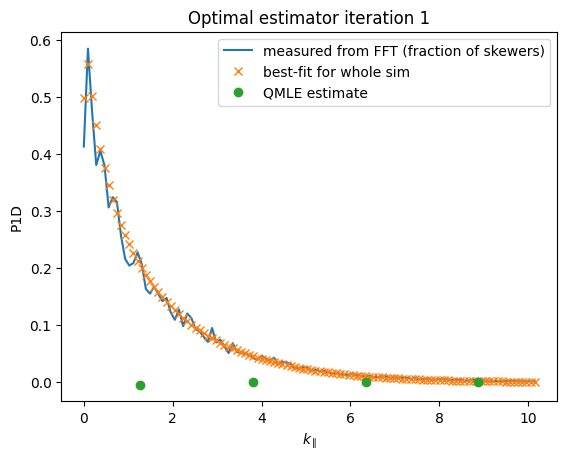

In [29]:
# plt.plot(kpar[1:5], P_kpar_est, 'o', label='estimate')
# plt.plot(kpar[1:], p1d[1:], label='fiducial')
plt.plot(kpar, pk_avg, label='measured from FFT (fraction of skewers)')
plt.plot(kpar, p1d, marker = 'x', linestyle='none', label='best-fit for whole sim')
plt.plot(kbin_est_centers, theta_est, 'o', label='QMLE estimate')
plt.legend()
plt.title("Optimal estimator iteration 1")
plt.ylabel("P1D")
plt.xlabel("$k_\parallel$")

# how do we get the $p_\alpha$ estimates?
(1) Make a first guess for $p_\alpha$

(2) At every iteration compute the covariance matrix using the previous estimates for $p_\alpha$

The covariance matrix is $C = S + N$; presumably covariances between parameters $p_\alpha$ therefore $N\times N$ where $N$ is number of power spectrum bins


(3) Compute $d_\alpha$, $b_\alpha$, $t_\alpha$ as in Naim 4,5,6 -- these have the observed $\delta_F$ vectors

(4) Compute

$$ \hat{p}_\alpha^{(X+1)} = \Sigma_{\alpha'} \frac{1}{2}F^{-1}_{\alpha \alpha'} (d_{\alpha'}-b_{\alpha'}-t_{\alpha'})$$

which is effectively giving the inverse-variance-weighted average of the residuals at each iteration.

(5)  Compute Fisher matrix. Note that this needs to consider all redshift bins that the spectrum spans.

(6) Check for convergence using eqns in 3.3 (Naim)

Notes from Andreu's paper:
Make the fiducial power spectrum P1D
